# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [1]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

In [47]:
import warnings 
warnings.filterwarnings('ignore')

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    

In [48]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [32]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [57]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [50]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [83]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [87]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [110]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 889.274017
Epoch 1, loss: 839.208329
Epoch 2, loss: 872.373188
Epoch 3, loss: 898.266490
Epoch 4, loss: 884.930384
Epoch 5, loss: 862.024798
Epoch 6, loss: 888.933789
Epoch 7, loss: 887.310190
Epoch 8, loss: 889.419000
Epoch 9, loss: 896.543694


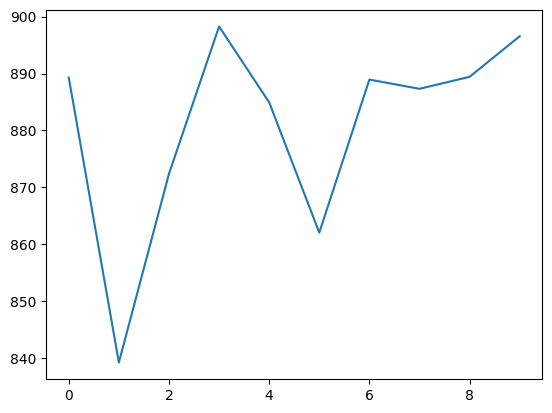

In [112]:
# let's look at the loss history!
plt.plot(loss_history)

In [114]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.119
Epoch 0, loss: 860.231620
Epoch 1, loss: 872.629516
Epoch 2, loss: 944.369217
Epoch 3, loss: 928.613256
Epoch 4, loss: 928.083193
Epoch 5, loss: 862.700603
Epoch 6, loss: 875.927968
Epoch 7, loss: 849.292254
Epoch 8, loss: 936.459951
Epoch 9, loss: 872.207162
Epoch 10, loss: 971.715846
Epoch 11, loss: 865.144833
Epoch 12, loss: 891.365896
Epoch 13, loss: 914.253366
Epoch 14, loss: 911.579314
Epoch 15, loss: 897.449050
Epoch 16, loss: 874.425368
Epoch 17, loss: 885.479268
Epoch 18, loss: 890.961471
Epoch 19, loss: 845.775171
Epoch 20, loss: 899.770460
Epoch 21, loss: 890.016157
Epoch 22, loss: 904.505870
Epoch 23, loss: 876.203235
Epoch 24, loss: 874.826374
Epoch 25, loss: 893.728744
Epoch 26, loss: 879.486742
Epoch 27, loss: 870.729546
Epoch 28, loss: 921.109170
Epoch 29, loss: 872.984400
Epoch 30, loss: 912.569731
Epoch 31, loss: 892.173938
Epoch 32, loss: 874.168139
Epoch 33, loss: 931.225568
Epoch 34, loss: 867.614786
Epoch 35, loss: 906.098919
Epoch 36, loss: 907.7

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [123]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

rez = {}
for lr in learning_rates:
    for rg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr,
                       batch_size=batch_size, reg=rg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        rez[lr,rg] = accuracy
        
# print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 869.111095
Epoch 1, loss: 881.311443
Epoch 2, loss: 903.744005
Epoch 3, loss: 867.411886
Epoch 4, loss: 903.419754
Epoch 5, loss: 868.703286
Epoch 6, loss: 860.336827
Epoch 7, loss: 858.845284
Epoch 8, loss: 835.955158
Epoch 9, loss: 813.709409
Epoch 10, loss: 836.227541
Epoch 11, loss: 838.611334
Epoch 12, loss: 828.200931
Epoch 13, loss: 808.805802
Epoch 14, loss: 835.181772
Epoch 15, loss: 778.618252
Epoch 16, loss: 832.434855
Epoch 17, loss: 756.732420
Epoch 18, loss: 826.696970
Epoch 19, loss: 772.822917
Epoch 20, loss: 877.648863
Epoch 21, loss: 846.734744
Epoch 22, loss: 750.470539
Epoch 23, loss: 801.858998
Epoch 24, loss: 780.759125
Epoch 25, loss: 839.672902
Epoch 26, loss: 768.206604
Epoch 27, loss: 821.287823
Epoch 28, loss: 783.193696
Epoch 29, loss: 864.829075
Epoch 30, loss: 797.391198
Epoch 31, loss: 785.296789
Epoch 32, loss: 747.941397
Epoch 33, loss: 797.895580
Epoch 34, loss: 764.803142
Epoch 35, loss: 855.817764
Epoch 36, loss: 775.433801
Epoch 37, l

Epoch 103, loss: 723.907547
Epoch 104, loss: 764.732251
Epoch 105, loss: 749.069071
Epoch 106, loss: 739.433324
Epoch 107, loss: 716.789828
Epoch 108, loss: 781.883712
Epoch 109, loss: 776.141813
Epoch 110, loss: 776.601055
Epoch 111, loss: 754.312582
Epoch 112, loss: 772.216471
Epoch 113, loss: 783.128594
Epoch 114, loss: 754.751182
Epoch 115, loss: 782.543371
Epoch 116, loss: 759.548276
Epoch 117, loss: 742.223284
Epoch 118, loss: 709.921258
Epoch 119, loss: 753.820689
Epoch 120, loss: 772.893156
Epoch 121, loss: 730.151482
Epoch 122, loss: 780.622308
Epoch 123, loss: 746.070269
Epoch 124, loss: 724.660097
Epoch 125, loss: 814.867520
Epoch 126, loss: 726.267703
Epoch 127, loss: 696.488852
Epoch 128, loss: 786.716589
Epoch 129, loss: 781.330622
Epoch 130, loss: 769.150613
Epoch 131, loss: 769.691963
Epoch 132, loss: 740.521436
Epoch 133, loss: 711.142558
Epoch 134, loss: 765.724908
Epoch 135, loss: 787.070160
Epoch 136, loss: 709.727881
Epoch 137, loss: 774.607001
Epoch 138, loss: 712

Epoch 0, loss: 688.426939
Epoch 1, loss: 681.672791
Epoch 2, loss: 676.443817
Epoch 3, loss: 671.980765
Epoch 4, loss: 668.108539
Epoch 5, loss: 664.957837
Epoch 6, loss: 662.335250
Epoch 7, loss: 659.965865
Epoch 8, loss: 658.165328
Epoch 9, loss: 656.113344
Epoch 10, loss: 654.489283
Epoch 11, loss: 653.166241
Epoch 12, loss: 652.039782
Epoch 13, loss: 650.857914
Epoch 14, loss: 649.732087
Epoch 15, loss: 648.840662
Epoch 16, loss: 648.119682
Epoch 17, loss: 647.128002
Epoch 18, loss: 646.412563
Epoch 19, loss: 645.623568
Epoch 20, loss: 645.069642
Epoch 21, loss: 644.514588
Epoch 22, loss: 644.134856
Epoch 23, loss: 643.497190
Epoch 24, loss: 642.879228
Epoch 25, loss: 642.358572
Epoch 26, loss: 641.947528
Epoch 27, loss: 641.532923
Epoch 28, loss: 641.021065
Epoch 29, loss: 640.710997
Epoch 30, loss: 640.193429
Epoch 31, loss: 639.631230
Epoch 32, loss: 639.350874
Epoch 33, loss: 638.886647
Epoch 34, loss: 638.614397
Epoch 35, loss: 638.441030
Epoch 36, loss: 637.962186
Epoch 37, l

Epoch 102, loss: 625.542879
Epoch 103, loss: 625.614616
Epoch 104, loss: 625.583141
Epoch 105, loss: 625.534215
Epoch 106, loss: 625.334265
Epoch 107, loss: 625.017908
Epoch 108, loss: 624.979606
Epoch 109, loss: 624.882894
Epoch 110, loss: 625.129307
Epoch 111, loss: 624.814706
Epoch 112, loss: 624.483266
Epoch 113, loss: 624.413363
Epoch 114, loss: 624.447626
Epoch 115, loss: 624.175190
Epoch 116, loss: 623.956658
Epoch 117, loss: 623.987048
Epoch 118, loss: 623.897435
Epoch 119, loss: 623.851325
Epoch 120, loss: 623.706296
Epoch 121, loss: 623.574213
Epoch 122, loss: 623.516406
Epoch 123, loss: 623.272541
Epoch 124, loss: 623.184350
Epoch 125, loss: 623.214411
Epoch 126, loss: 623.242610
Epoch 127, loss: 623.074062
Epoch 128, loss: 623.032320
Epoch 129, loss: 622.943211
Epoch 130, loss: 622.564217
Epoch 131, loss: 622.654209
Epoch 132, loss: 622.369665
Epoch 133, loss: 622.501127
Epoch 134, loss: 622.299662
Epoch 135, loss: 622.331948
Epoch 136, loss: 622.137639
Epoch 137, loss: 621

Epoch 199, loss: 617.508846
Epoch 0, loss: 690.468225
Epoch 1, loss: 689.588121
Epoch 2, loss: 688.806702
Epoch 3, loss: 688.026997
Epoch 4, loss: 687.279499
Epoch 5, loss: 686.551719
Epoch 6, loss: 685.843980
Epoch 7, loss: 685.147644
Epoch 8, loss: 684.485397
Epoch 9, loss: 683.815077
Epoch 10, loss: 683.175236
Epoch 11, loss: 682.539026
Epoch 12, loss: 681.918893
Epoch 13, loss: 681.308701
Epoch 14, loss: 680.703523
Epoch 15, loss: 680.133386
Epoch 16, loss: 679.547944
Epoch 17, loss: 678.992874
Epoch 18, loss: 678.441965
Epoch 19, loss: 677.913869
Epoch 20, loss: 677.396251
Epoch 21, loss: 676.845989
Epoch 22, loss: 676.344849
Epoch 23, loss: 675.826482
Epoch 24, loss: 675.346075
Epoch 25, loss: 674.869520
Epoch 26, loss: 674.393816
Epoch 27, loss: 673.924983
Epoch 28, loss: 673.473359
Epoch 29, loss: 673.014152
Epoch 30, loss: 672.594304
Epoch 31, loss: 672.151742
Epoch 32, loss: 671.729844
Epoch 33, loss: 671.297407
Epoch 34, loss: 670.892326
Epoch 35, loss: 670.482110
Epoch 36, 

Epoch 100, loss: 654.105433
Epoch 101, loss: 653.940855
Epoch 102, loss: 653.786180
Epoch 103, loss: 653.657544
Epoch 104, loss: 653.488327
Epoch 105, loss: 653.353957
Epoch 106, loss: 653.218427
Epoch 107, loss: 653.069371
Epoch 108, loss: 652.939393
Epoch 109, loss: 652.799917
Epoch 110, loss: 652.656144
Epoch 111, loss: 652.523176
Epoch 112, loss: 652.383183
Epoch 113, loss: 652.242765
Epoch 114, loss: 652.109112
Epoch 115, loss: 651.984627
Epoch 116, loss: 651.872542
Epoch 117, loss: 651.732792
Epoch 118, loss: 651.603624
Epoch 119, loss: 651.476382
Epoch 120, loss: 651.371063
Epoch 121, loss: 651.240065
Epoch 122, loss: 651.103054
Epoch 123, loss: 650.995547
Epoch 124, loss: 650.880670
Epoch 125, loss: 650.751546
Epoch 126, loss: 650.637660
Epoch 127, loss: 650.523853
Epoch 128, loss: 650.411874
Epoch 129, loss: 650.323150
Epoch 130, loss: 650.185312
Epoch 131, loss: 650.078966
Epoch 132, loss: 649.974909
Epoch 133, loss: 649.873769
Epoch 134, loss: 649.744391
Epoch 135, loss: 649

Epoch 199, loss: 644.383084


In [146]:
best_lr, best_rs = [gp for gp, acc in rez.items() if acc==max(rez.values())][0][0],\
                    [gp for gp, acc in rez.items() if acc==max(rez.values())][0][1]

In [149]:
best_classifier = linear_classifer.LinearSoftmaxClassifier()
best_classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=best_lr,
                       batch_size=batch_size, reg=best_rs)

Epoch 0, loss: 688.252777
Epoch 1, loss: 681.831064
Epoch 2, loss: 676.264343
Epoch 3, loss: 671.914741
Epoch 4, loss: 668.227510
Epoch 5, loss: 665.143367
Epoch 6, loss: 662.236495
Epoch 7, loss: 659.769124
Epoch 8, loss: 657.846165
Epoch 9, loss: 656.285968
Epoch 10, loss: 654.718215
Epoch 11, loss: 653.199831
Epoch 12, loss: 651.818965
Epoch 13, loss: 650.913702
Epoch 14, loss: 649.802409
Epoch 15, loss: 648.988600
Epoch 16, loss: 647.983733
Epoch 17, loss: 647.262470
Epoch 18, loss: 646.534219
Epoch 19, loss: 645.913587
Epoch 20, loss: 645.184965
Epoch 21, loss: 644.379870
Epoch 22, loss: 644.025952
Epoch 23, loss: 643.326542
Epoch 24, loss: 642.950182
Epoch 25, loss: 642.409273
Epoch 26, loss: 641.869904
Epoch 27, loss: 641.314618
Epoch 28, loss: 640.928594
Epoch 29, loss: 640.329443
Epoch 30, loss: 640.204253
Epoch 31, loss: 639.719524
Epoch 32, loss: 639.237425
Epoch 33, loss: 638.968474
Epoch 34, loss: 638.508827
Epoch 35, loss: 638.377307
Epoch 36, loss: 638.055966
Epoch 37, l

[688.2527765913826,
 681.8310643475226,
 676.2643427412991,
 671.9147414691951,
 668.2275100743637,
 665.1433671931263,
 662.236494630657,
 659.7691243001384,
 657.8461650028083,
 656.2859679187364,
 654.7182153226719,
 653.1998314892285,
 651.8189653869514,
 650.9137022529011,
 649.8024085846841,
 648.9886003876903,
 647.9837325008367,
 647.2624697778563,
 646.5342187526719,
 645.9135872692207,
 645.1849646511672,
 644.3798697336003,
 644.0259519000371,
 643.326541996434,
 642.9501820860795,
 642.409273495477,
 641.869903870963,
 641.3146177262636,
 640.92859440988,
 640.3294431828659,
 640.2042531166666,
 639.7195235916821,
 639.2374250089999,
 638.9684742243269,
 638.5088271011266,
 638.3773068595814,
 638.0559658057548,
 637.763133174429,
 637.2162285170132,
 636.8748474140316,
 636.5682832441034,
 636.3574874920447,
 635.9799432918005,
 635.8961671379226,
 635.6026532713331,
 635.2361857282461,
 634.9644404596514,
 634.9160497552282,
 634.5358878098,
 634.2571509946214,
 634.22319

# Какой же точности мы добились на тестовых данных?

In [150]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.211000
